In [1]:
# pipeline derived from joint work with Yikuan Li

In [2]:
import pyspark

In [7]:
import sys 
sys.path.insert(0, '/home/rnshishir/deepmed/CPRD_Cut22/')
import shutil
from utils.yaml_act import yaml_load
from utils.arg_parse import arg_paser
from CPRD.config.spark import spark_init, read_parquet
import pyspark.sql.functions as F
from CPRD.functions import tables, merge
from CPRD.functions import merge
from utils.utils import save_obj
from CPRD.functions.MedicalDictionary import * 
from CPRD.functions.Prediction import * 
from CPRD.functions.cohort_select import * 
from CPRD.functions.SurvPrediction import * 
from CPRD.functions.merge import *

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [8]:

def vocabCreate(CountsICD, num):
    dic={}
    dic['token2idx']={}
    dic['idx2token']={}
    dic['token2idx']['MASK']=4
    dic['token2idx']['CLS']=3
    dic['token2idx']['SEP']=2
    dic['token2idx']['UNK']=1
    dic['token2idx']['PAD']=0
    dic['idx2token'][4]='MASK'
    dic['idx2token'][3]='CLS'
    dic['idx2token'][2]='SEP'
    dic['idx2token'][1]='UNK'
    dic['idx2token'][0]='PAD'
    i=5
    for x in CountsICD:
        if CountsICD[x]>num:
            dic['token2idx'][x]=i
            dic['idx2token'][i]=x
            i=i+1
    return dic

In [9]:
args = dotdict({'params': '/home/rnshishir/deepmed/CPRD_Cut22/config/config.yaml'})
params = yaml_load(args.params)
spark_params = params['pyspark']
spark = spark_init(spark_params)
file = params['file_path']
data_params = params['params']

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=ehr, master=local[*]) created by __init__ at /home/rnshishir/deepmed/CPRD_Cut22/CPRD/config/spark.py:35 

In [10]:
# params have each of the individual files for data processing and other things like location of medical dict etc
params

{'task': 'medication.main',
 'pyspark': {'temp': '/home/rnshishir/sparkNewT',
  'pyspark_env': '/home/rnshishir/anaconda3/envs/pyspark37/bin/python3.7'},
 'file_path': {'clinical': '/home/workspace/datasets/cprd/cprd2021/*/*_Observation_*',
  'patient': '/home/workspace/datasets/cprd/cprd2021/*/*_Patient_*',
  'problem': '/home/workspace/datasets/cprd/cprd2021/*/*_Problem_*',
  'therapy': '/home/workspace/datasets/cprd/cprd2021/*/*_DrugIssue_*',
  'referral': '/home/workspace/datasets/cprd/cprd2021/*/*_Referral_*',
  'practice': '/home/workspace/datasets/cprd/cprd2021/*/*_Practice_*',
  'consultation': '/home/workspace/datasets/cprd/cprd2021/*/*_Consultation_*',
  'staff': '/home/workspace/datasets/cprd/cprd2021/*/*_Staff*',
  'diagnosis_hes': '/home/workspace/datasets/cprd/cprd2021/linkage/20_095_Results/*/Aurum_linked/Final/hes_diagnosis_hosp_20_095_DM.txt',
  'proc_hes': '/home/workspace/datasets/cprd/cprd2021/linkage/20_095_Results/*/Aurum_linked/Final/hes_procedures_epi_20_095_DM.

# cohort selection
### Ischaemic events risk prediction

-Cohort selection: age between 70 and 71 years in years between 2012 and 2013 with 1 year reg GP

-we select random baseline

-3 year followup

In [7]:
# a random cut cohort
cohortselector = CohortRandomCut(least_year_register_gp=1, least_age=70, greatest_age=150)
cohort = cohortselector.pipeline(file,spark, duration=('2019-01-01', '2020-01-01'))\
                .select(['patid', 'gender', 'dob', 'region', 'study_entry', 'start', 'startdate', 'end', 'enddate'])

cohort.write.parquet('/home/shared/shishir/AurumOut/rawDat/cohort_survpred_example_70150_2003_2020.parquet')

cohort = read_parquet(spark.sqlContext,'/home/shared/shishir/AurumOut/rawDat/cohort_survpred_example_70150_2003_2020.parquet')



outcome selection

In [15]:
cohort = read_parquet(spark.sqlContext,'/home/shared/shishir/AurumOut/rawDat/cohort_survpred_example_7071.parquet')
cohort = cohort.sample(withReplacement=False,fraction=0.002)



In [16]:
cohort.count()

364

In [17]:
# label codes phenotyping from medical dict - ie maybe ischaemic conditions
md = MedicalDictionaryRiskPrediction(file, spark)

labelcodes  = md.queryDisease(md.findItem('ischaem'), merge= True)['merged']
allIschaemiaCodes = labelcodes['medcode'] + labelcodes['ICD10'] +labelcodes['OPCS']

In [18]:
# label codes phenotyping from medical dict - ie maybe ischaemic conditions

# split diags into icd and nonicd(medcode) and re-union as "code"
allDiag = split_combine_diag (spark , '/home/shared/shishir/AurumOut/rawDat/diagGP_med2sno2icd_HESAPC_praclinkage_1985_2021.parquet')

# read death registry as death is an important data source for looking for outcome  
death = tables.retrieve_death(dir=file['death'], spark=spark)

In [20]:
survival_outcome_selector = SurvRiskPredictionBase(follow_up_duration_month=36)
# pipeline for capturing the event and time2event is below
rcohort = survival_outcome_selector.setupEventAndTime(cohort, source=allDiag, condition=allIschaemiaCodes, column='code', death=death)

rcohort. write.parquet('rpred_test_7071_2.parquet')


In [21]:
rcohort = pd.read_parquet('rpred_test_7071.parquet')

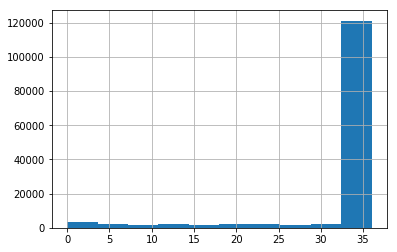

In [24]:
rcohort.time.hist()